# Click detection

## load data

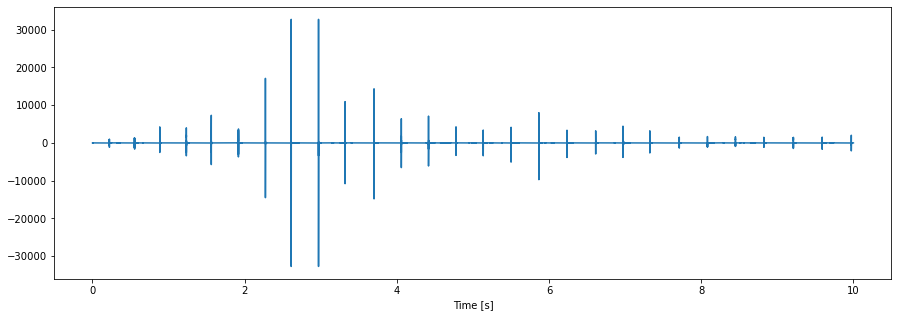

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import wave, struct

# load some data from wav files
def wavLoad(fname,t1,dt):
    wf = wave.open(fname, 'rb')
    nframes=wf.getnframes()
    nsw=wf.getsampwidth()
    fs=wf.getframerate()
    nch=wf.getnchannels()
    nbuf=int(dt*fs)
    wf.setpos(int(t1*fs))
    buf=wf.readframes(nbuf)
    wf.close()
    data = np.array(struct.unpack('{n}h'.format(n=nbuf*nch),buf))
    return data,fs,nch

# data from https://www.mobysound.org/odontocetes/Ziphius_Italy-Annotated.zip
# copied to ./Data/
data,fs,nch=wavLoad("./Data/zc06_204a22410-24210.wav",4,10)

tt=np.arange(np.shape(data)[0])/fs
fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,data)
plt.xlabel("Time [s]");


In [2]:
from numba import jit

@jit(nopython=True,cache=True)
def peak1(xx,leak):
    ndat=len(xx)
    yy=1.0*xx
    for ii in range(1,ndat):
        yy[ii]=np.maximum(xx[ii],yy[ii-1]*leak)
    return yy

#@jit(nopython=True,cache=True)
def pageTest1(zz,th,bb,aa,nt):
    ee=0*zz
    dd=0*zz
    nn=0*zz
    sn=0*zz

    no=np.sum(zz[:100],0)/100
    nn[0]=no
    #
    sn[0]=zz[0]/nn[0]
    #
    ndat=len(zz)
    
    it=0
    for ii in range(1,ndat):
        sn[ii]=zz[ii]/nn[ii-1]
        ee[ii]= ee[ii-1]+(sn[ii]-bb)
        if (ee[ii]>th):
            ee[ii]=th
            dd[ii]=1
            if ii-it>=nt:
                ee[it:ii]=th
                dd[it:ii]=1
        if (ee[ii]<0):
            ee[ii]=0
            nn[ii]=nn[ii-1]+aa*(zz[ii]-nn[ii-1])
            it=ii
        else:
            nn[ii]=nn[ii-1]
                
    return dd,nn

In [3]:
yy=peak1(data**2,0.97)
dd,nn=pageTest1(yy,20,6,1e-3,10)

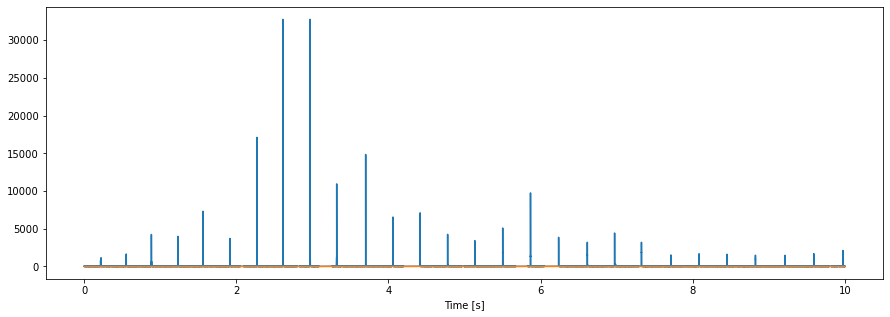

In [6]:
fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.sqrt(yy),tt,np.sqrt(nn))
plt.xlabel("Time [s]");


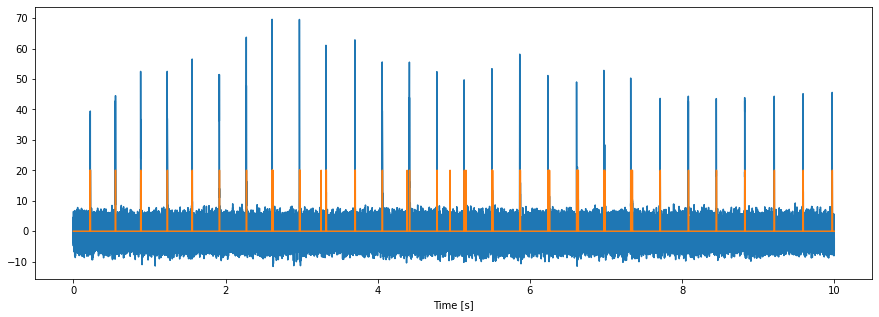

In [7]:

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,10*np.log10(yy/nn))
plt.plot(tt,20*dd)
plt.xlabel("Time [s]");

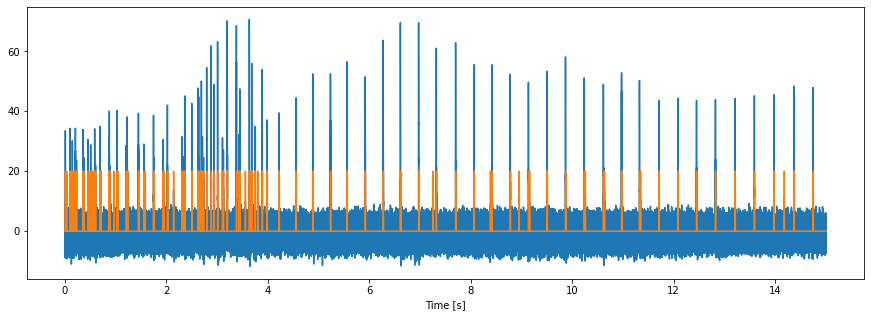

In [21]:
data,fs,nch=wavLoad("./Data/zc06_204a22410-24210.wav",0, 15)
tt=np.arange(np.shape(data)[0])/fs

yy=peak1(data**2,0.97)
dd,nn=pageTest1(yy,20,6,1e-3,10)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,10*np.log10(yy/nn))
plt.plot(tt,20*dd)
plt.xlabel("Time [s]");


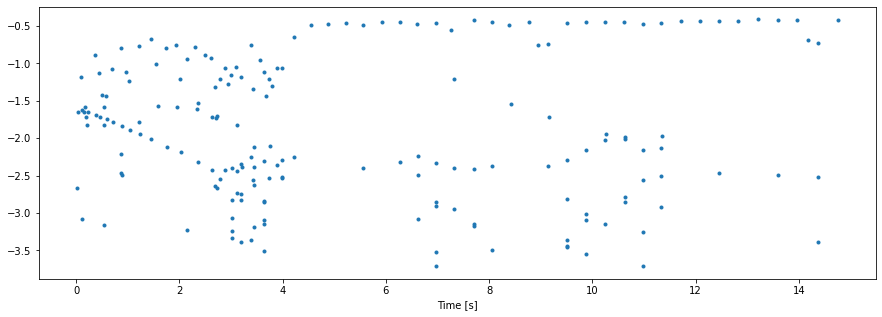

In [24]:
t1 = np.diff(dd,1,0,prepend=[0])
tcl= tt[t1>0]
ici = np.diff(tcl)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tcl[1:],np.log10(ici),'.')
plt.xlabel("Time [s]");